In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
train_dataset_path = '/content/drive/MyDrive/sensing localy.v1i.tensorflow/train'
validation_dataset_path = '/content/drive/MyDrive/sensing localy.v1i.tensorflow/valid'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 165 images belonging to 4 classes.


In [7]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',shuffle=True)


Found 33 images belonging to 4 classes.


In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Encroachment
1 : Footpath Quality
2 : Obstruction
3 : Waste


Text(0.5, 0.98, 'Sample Training Images')

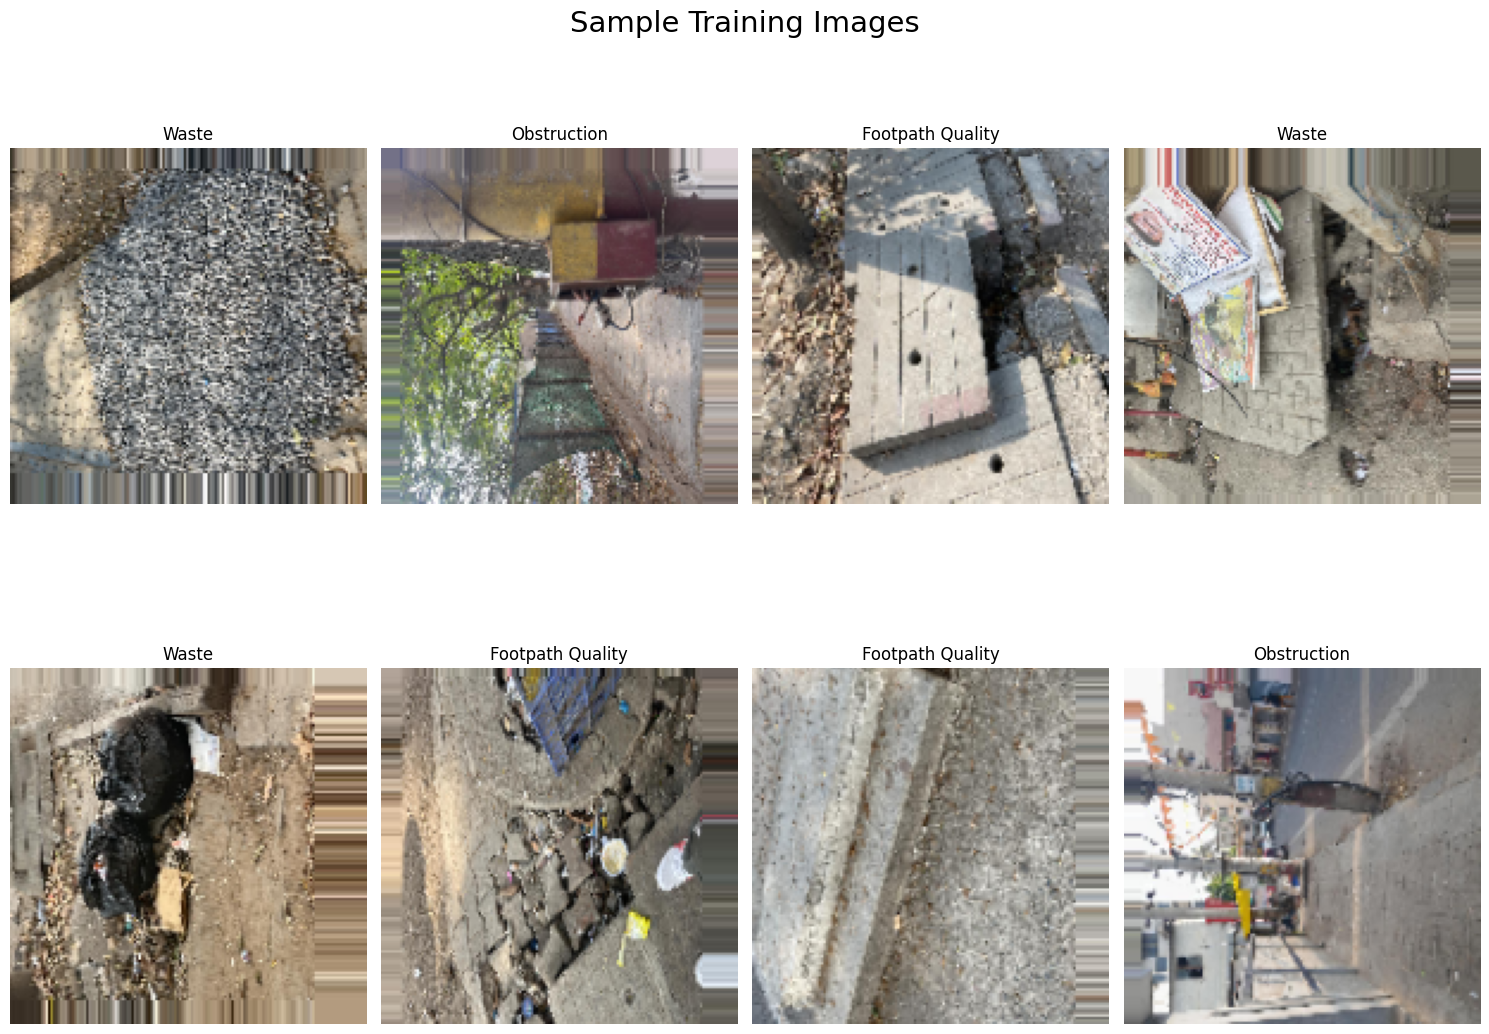

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)

In [10]:
plt.show()

In [11]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=4, activation='softmax')
    ])

    return model

In [12]:
cnn_model = create_model()

In [13]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [15]:
optimizer = Adam(learning_rate=0.001)

In [16]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
6/6 - 81s - loss: 3.4168 - accuracy: 0.2727 - val_loss: 1.4254 - val_accuracy: 0.2727 - lr: 0.0010 - 81s/epoch - 14s/step
Epoch 2/50
6/6 - 43s - loss: 2.1905 - accuracy: 0.5576 - val_loss: 1.4612 - val_accuracy: 0.3939 - lr: 0.0010 - 43s/epoch - 7s/step
Epoch 3/50
6/6 - 32s - loss: 2.9305 - accuracy: 0.4242 - val_loss: 1.7890 - val_accuracy: 0.2727 - lr: 0.0010 - 32s/epoch - 5s/step
Epoch 4/50
6/6 - 31s - loss: 2.1722 - accuracy: 0.5333 - val_loss: 3.3075 - val_accuracy: 0.3939 - lr: 0.0010 - 31s/epoch - 5s/step
Epoch 5/50
6/6 - 31s - loss: 2.0106 - accuracy: 0.5818 - val_loss: 4.2718 - val_accuracy: 0.3939 - lr: 0.0010 - 31s/epoch - 5s/step
Epoch 6/50
6/6 - 30s - loss: 1.9606 - accuracy: 0.5636 - val_loss: 3.5150 - val_accuracy: 0.3939 - lr: 0.0010 - 30s/epoch - 5s/step
Epoch 7/50
6/6 - 30s - loss: 1.8592 - accuracy: 0.5939 - val_loss: 3.3705 - val_accuracy: 0.3939 - lr: 3.1623e-04 - 30s/epoch - 5s/step
Epoch 8/50
6/6 - 31s - loss: 1.6013 - accuracy: 0.6606 - val_loss: 3.17

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

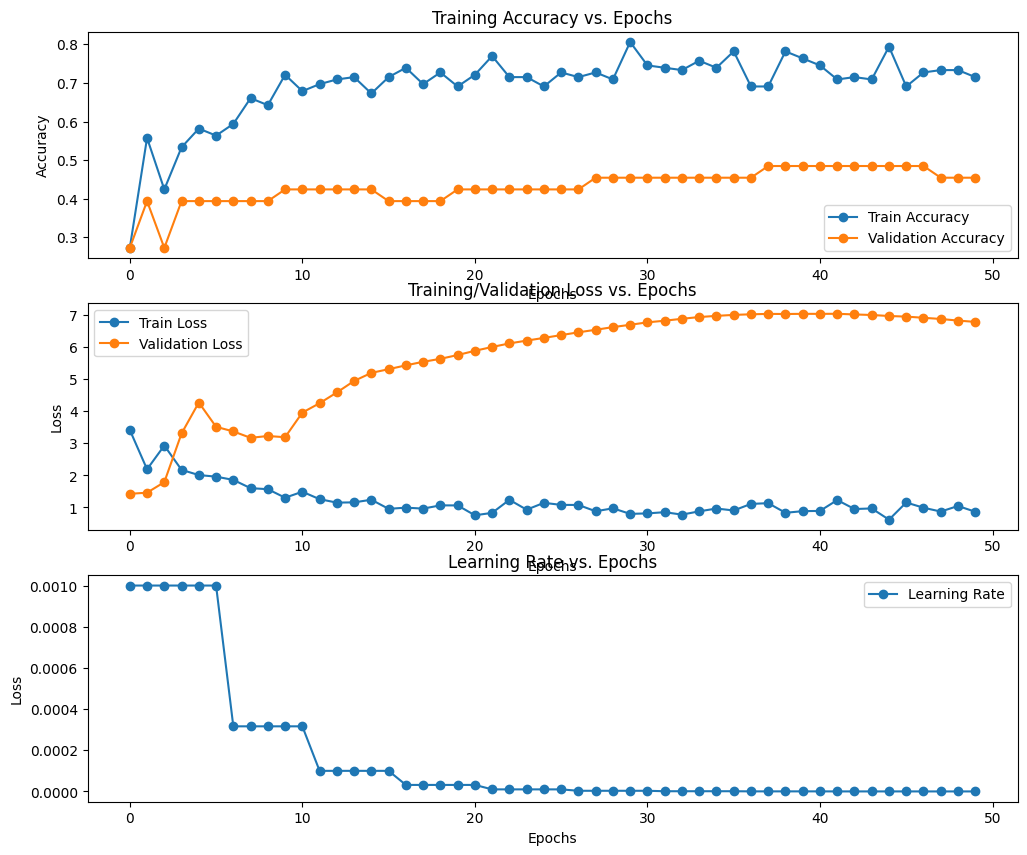

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [21]:
test_dataset = '/content/drive/MyDrive/sensing localy.v1i.tensorflow/test/'


In [22]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 14 images belonging to 4 classes.


In [23]:
predictions = cnn_model.predict(test_generator)


1/1 [==============================] - 1s 1s/step


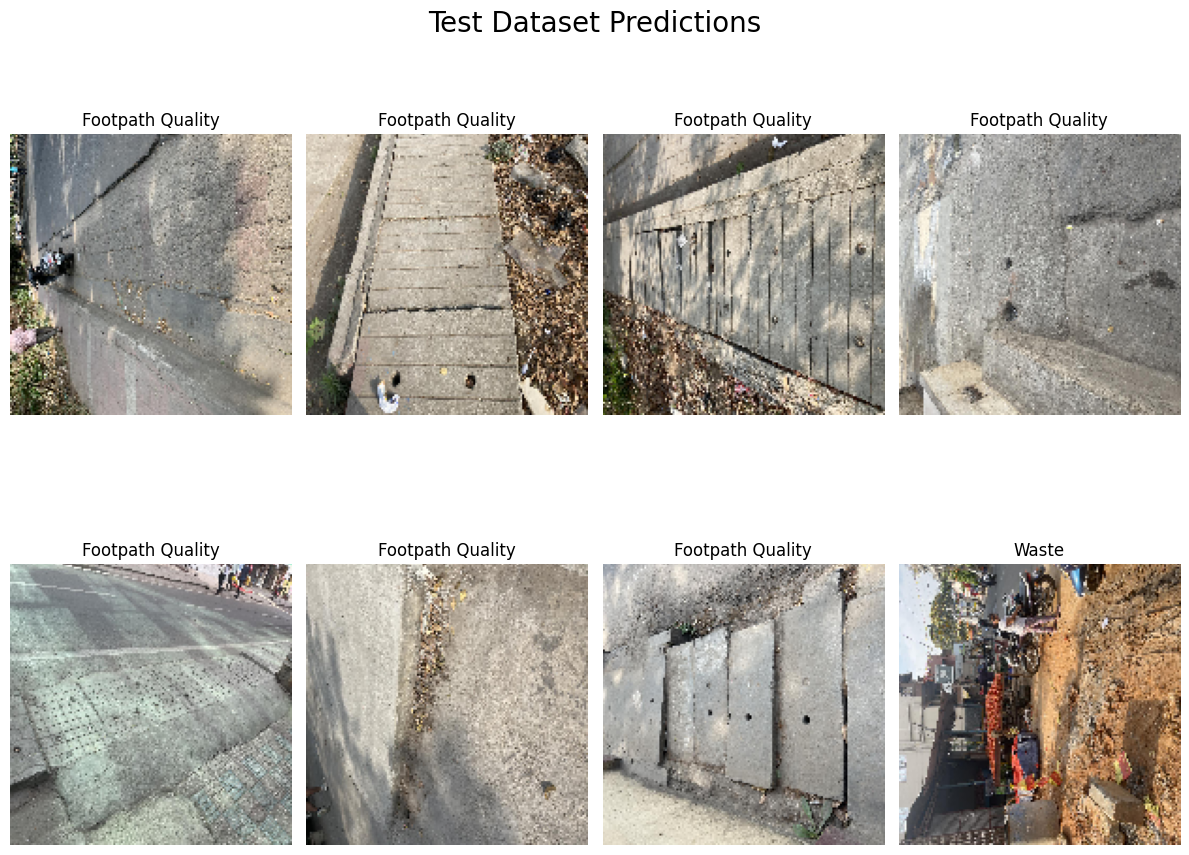

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
res = plt.show()

In [27]:
res

In [28]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)


1/1 [==============================] - 2s 2s/step - loss: 4.3509 - accuracy: 0.6429


In [29]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     4.350900650024414
Test Accuracy: 0.6428571343421936


In [30]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

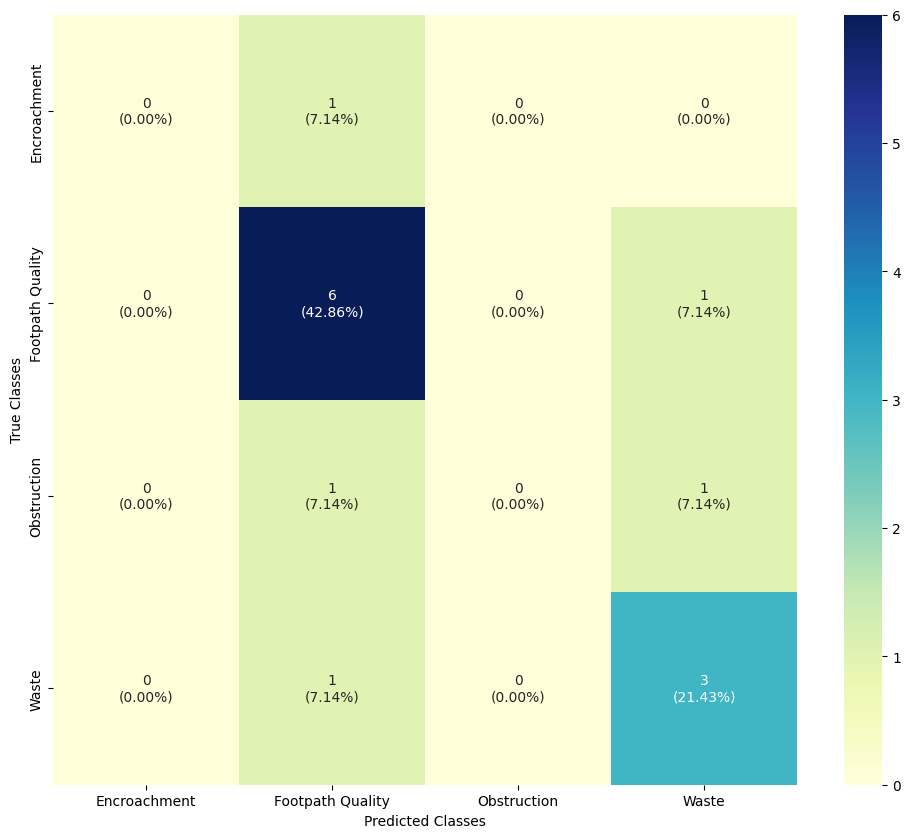

In [31]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [34]:
import pickle
pickle.dump(cnn_model, open("model.pkl", "wb"))

In [42]:

cnn_model.save('cnn_model.h5')

In [35]:
!pip install flask-ngrok

In [40]:
from flask_ngrok import run_with_ngrok
import numpy as np
from flask import Flask, request, jsonify, render_template
import pickle
app = Flask(__name__)
model = pickle.load(open("model.pkl", "rb"))
run_with_ngrok(app)

@app.route("/")
def home():
    return "<h1>Sensing Local</h1>"

@app.route("/predict",methods=["POST"])
def predict():
  #data=request.get_json()
  #float_features=[[data[i]["Sepal_Length"],data[i]["Sepal_Width"],data[i]["Petal_Length"],data[i]["Petal_Width"]] for i in range(len(data))]
  predictions = cnn_model.predict(test_generator)
  fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
  idx = 0

  for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

  plt.tight_layout()
  plt.suptitle("Test Dataset Predictions", fontsize=20)
  plt.show()
  #print(res)

  #prediction_text = "The flower species is {}".format(predictions)

  return (res)

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-30:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 714, in urlopen
    httplib_response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packag